# Image Filtering

The main objectives of this module are:

* Implement point filtering with look-up tables.
* Implement region filtering with kernel convolution, morphological operations and edge detection.
* Understand spatial frequency information with the Fourier transform.

## 1. Look-up tables

Look-up tables are a very useful tool to perform simple pixel-level filtering of an image.

Numpy arrays indexing ([see reference here](http://docs.scipy.org/doc/numpy/user/basics.indexing.html)) is a very powerful tool, but can be a bit counter-intuitive at first. We will use it to quickly create and use look-up tables to transform an image.

Look at the short example below. 

We construct an image with 4 possible values for each pixel (-> $I(x,y) \in \{0,1,2,3\}$). We then build the following LUT:

|Input value|Output value|
|--|--|
|0|2|
|1|3|
|2|1|
|3|0|

And we apply it on the image.

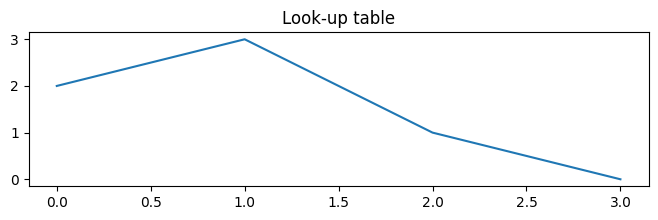

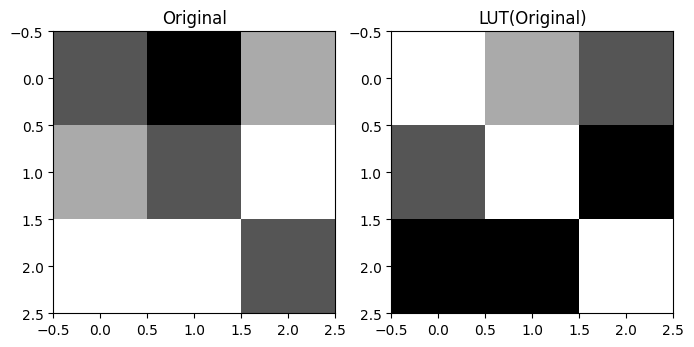

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

original_walking = plt.imread('data/walking.jpg')

# Let's create a 3x3 "image" with 4 possible pixel values (in [0,3])
im = np.array([[1,0,2],[2,1,3],[3,3,1]])

# look-up table is a vector of size 4 mapping the new value for the pixels of m
lut = np.array([2,3,1,0]) # maps 0 -> 2, 1 -> 3, 2 -> 1, 3 -> 0

plt.figure(figsize=(8,2))
plt.plot(lut)
plt.title('Look-up table')
plt.show()

# we can use numpy vector indexing to apply the look-up table:
new_im = lut[im] # This will create a new array with the same size as m

plt.figure(figsize=(8,4))
plt.subplot(1,2,1) #supblot is useful to display images side-by-side
plt.imshow(im, cmap=cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(new_im, cmap=cm.gray)
plt.title('LUT(Original)')
plt.show()

So a LUT for a grayscale image will be a 256-length vector. The first value in this vector will be the "new value to give all pixels that are equal to 0 in the original image".

For inverting a greyscale image, this would mean that we want all 0s to become 255s, all 1s to become 254s, etc...

In [2]:
lut_inv = np.zeros(256)

for i in range(256):
    lut_inv[i] = 255 -i

**Starting from this example, create the following LUTs** and apply them to the "walking.jpg" image:
1. For inverting an image (so that $0 \rightarrow 255$, $255 \rightarrow 0$)
1. To keep only graylevel such that $g \ge t$, setting all other values to 0.
1. To reduce the number of gray levels from 256 to 8 (so that $255 \rightarrow 7$, $0 \rightarrow 0$).
1. To "stretch" the histogram so that, given a **minimum value** $T_{min}$ and a **maximum value** $T_{max}$, we have :
    * If $I(x,y) < T_{min}$, the new value is set to 0
    * If $I(x,y) > T_{max}$, the new value is set to 255
    * Values between $T_{min}$ and $T_{max}$ are stretched to cover the entire histogram.
1. to perform an **equalization** of the walking.jpg image (so that the histogram becomes "as flat as possible")

C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\416570377.py:10: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(imgWalking)
c:\Users\tajan\Documents\COURS\ImageProcessing\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


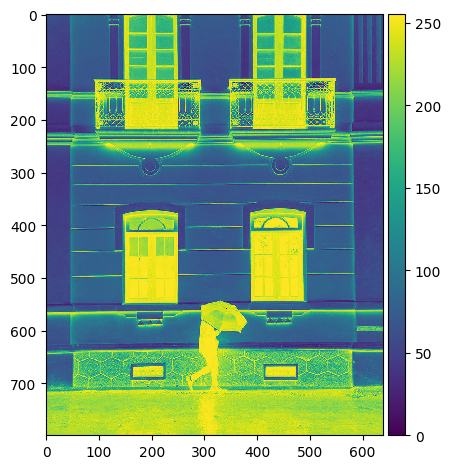

In [3]:
#1. For inverting an image

from skimage.io import imread,imshow,imsave

imgWalking = imread("data/walking.jpg")

#inverting
imgWalking = lut_inv[imgWalking]

imshow(imgWalking)

C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\2199390295.py:19: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(Graylevels_above_threshold)


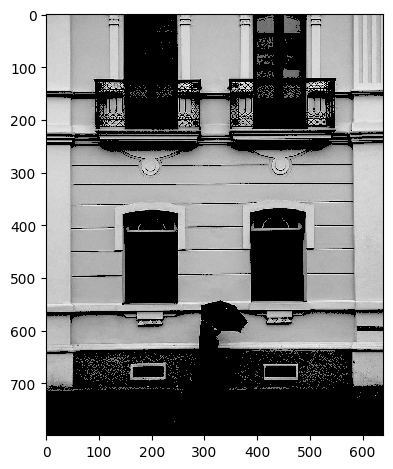

In [4]:
#2 Keep graylevels above a certain threshold

img_pour_index = (imgWalking * 255).astype(np.uint8)

threshold = 100

lut_threshold = np.zeros(256, dtype=np.uint8) 

for i in range(256):
    if i >= threshold:
        lut_threshold[i] = i
    else:
        lut_threshold[i] = 0

# print(lut_threshold)

Graylevels_above_threshold = lut_threshold[img_pour_index] 

imshow(Graylevels_above_threshold)

Let's have a quick look at the effect on the histogram:

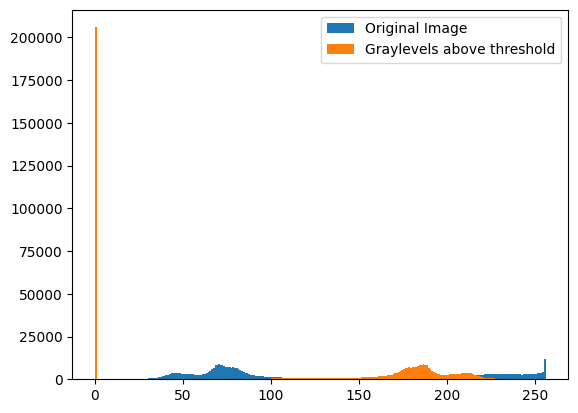

In [5]:
#Printing the histogram

plt.hist(imgWalking.ravel(), bins=256, range=(0, 256))
plt.hist(Graylevels_above_threshold.ravel(), bins=256, range=(0, 256))
plt.legend(['Original Image', 'Graylevels above threshold'])
plt.show()

As we can see, we have a huge peak at 0, as all pixels that had a value between 0 and the threshold have been set to 0. The rest of the histogram has the same shape as before (except it obviously looks flatter next to the 0 peak).



Next, we want to reduce the number of gray levels from 256 to 8 (meaning that we reduce the "dynamic range" of the image). So we want lut[0] = 0 and lut[255] = 7:

C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\3678062856.py:22: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(lessGrayLevels)


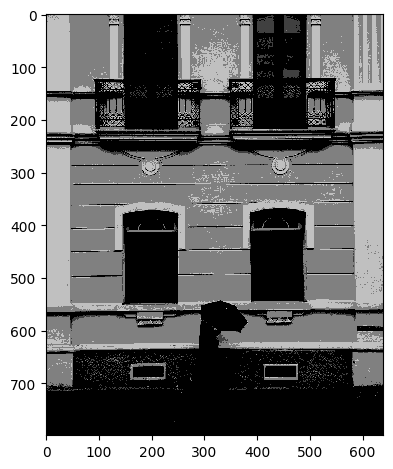

In [16]:
#3 Divide graylevels into fewer levels

# Ensure imgWalking can be used as indices: convert to a single-channel uint8 image (0..255)
from skimage.color import rgb2gray

# If image is float in [0,1], scale to 0-255; if RGB, convert to gray first
if imgWalking.dtype.kind == 'f':
    img_idx = (imgWalking * 255.0).round().astype(np.uint8)
else:
    img_idx = imgWalking.astype(np.uint8)

if img_idx.ndim == 3 and img_idx.shape[2] in (3,4):
    img_idx = (rgb2gray(img_idx) * 255.0).round().astype(np.uint8)

# Build LUT and apply
lut_lessGrayLevels = np.zeros(256, dtype=np.uint8)
for i in range(256):
    lut_lessGrayLevels[i] = (i // 64) * 64  # 4 levels: 0,64,128,192

lessGrayLevels = lut_lessGrayLevels[Graylevels_above_threshold.astype(np.uint8)]

imshow(lessGrayLevels)

Now we want to "stretch" the histogram by doing an auto-level. The goal of stretching the histogram is to better use the dynamic range. If we look at the histogram from the original image, we can see that we mostly don't use values above around 220. 

In other words, there are very few "bright" pixels in the image. On the other end, we do have black pixels, so we don't need to stretch in that direction. For the purpose of demonstrating histogram stretching, however, we will still use a T_min of 5.

C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\660858081.py:38: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(stretched_img)


C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\660858081.py:38: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(stretched_img)


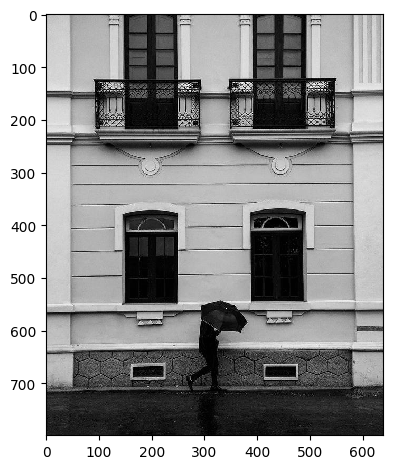

C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\660858081.py:38: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(stretched_img)


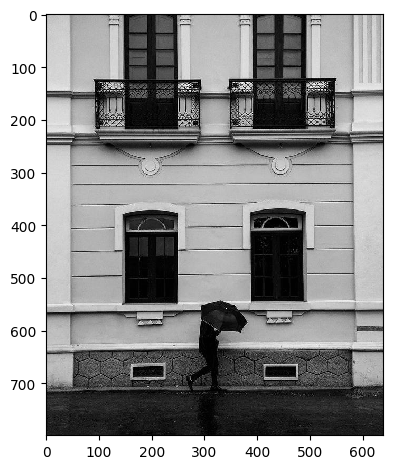

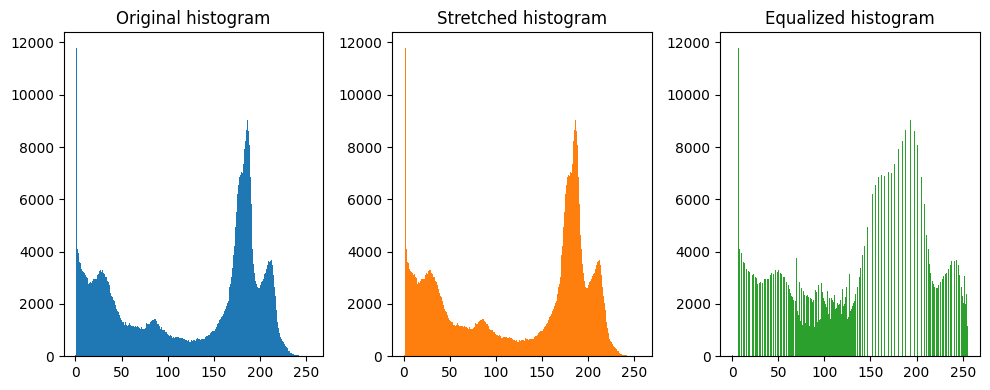

In [20]:
#4 To "stretch" the histogram (robust implementation)
from skimage.color import rgb2gray

# Ensure we have a single-channel uint8 image for indexing (0..255)
if imgWalking.dtype.kind == 'f':
    img_idx = (imgWalking * 255.0).round().astype(np.uint8)
else:
    img_idx = imgWalking.astype(np.uint8)

if img_idx.ndim == 3 and img_idx.shape[2] in (3,4):
    # convert RGB/RGBA to grayscale then to uint8
    img_idx = (rgb2gray(img_idx) * 255.0).round().astype(np.uint8)

# Compute min/max (you can replace these by percentiles if preferred)
min_val = int(np.min(img_idx))
max_val = int(np.max(img_idx))

# Build LUT robustly (handle case max==min)
if max_val == min_val:
    # no dynamic range -> identity LUT
    lut_stretch = np.arange(256, dtype=np.uint8)
else:
    lut_stretch = np.zeros(256, dtype=np.uint8)
    scale = 255.0 / float(max_val - min_val)
    for i in range(256):
        if i < min_val:
            lut_stretch[i] = 0
        elif i > max_val:
            lut_stretch[i] = 255
        else:
            lut_stretch[i] = np.round((i - min_val) * scale).astype(np.uint8)

# Apply LUT using the integer index image
stretched_img = lut_stretch[img_idx]

# Display stretched image
from skimage.io import imshow
imshow(stretched_img)

# Simple LUT equalization implementation (returns 256-length uint8 LUT)
def lut_equalization(ima):
    # ima expected to be integer image in 0..255
    hist, _ = np.histogram(ima.flatten(), bins=256, range=(0,256))
    nh = hist.astype(np.float64) / hist.sum()
    ch = np.cumsum(nh)
    lut = np.round(255 * ch).astype(np.uint8)
    return lut

# apply equalization and show result (optional)
eq_lut = lut_equalization(img_idx)
equalized = eq_lut[img_idx]

# Plot histograms: original vs stretched vs equalized
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title('Original histogram')
plt.hist(img_idx.ravel(), bins=256, range=(0,256), color='C0')

plt.subplot(1,3,2)
plt.title('Stretched histogram')
plt.hist(stretched_img.ravel(), bins=256, range=(0,256), color='C1')

plt.subplot(1,3,3)
plt.title('Equalized histogram')
plt.hist(equalized.ravel(), bins=256, range=(0,256), color='C2')
plt.tight_layout()
plt.show()

With that, we make the "bright" parts of the image "whiter", and the dark part darker, without losing much information in the process. A way to automate the selection of the thresholds would be to use percentiles in the cumulative histogram. For instance, we could say that we use the percentiles 2 and 98 as lower and upper thresholds, so as to only "lose" 4\% of the pixel information in the process:

C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\3491239693.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(equalized)


C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\3491239693.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(equalized)


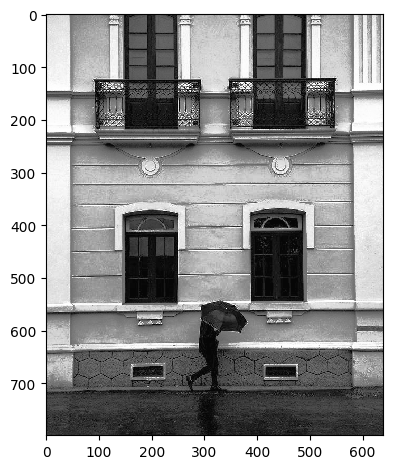

In [21]:
imshow(equalized)

C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\4203290241.py:5: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(equalized)


C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\4203290241.py:5: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(equalized)


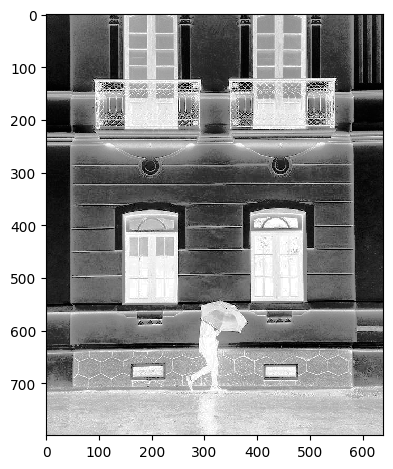

In [22]:
# Compute LUT & apply to image:

eq_lut = lut_equalization(imgWalking)
equalized = eq_lut[imgWalking.astype(np.uint8)]
imshow(equalized)

This time, Tmin has been set as 0 (so we don't modify the dark tones of the image), and Tmax at 217. The image,which was a bit underexposed, now has a better contrast (but this operation is not lossless!).

We now need to do equalization. The goal of equalization is to distribute the histogram as equally as possible. This is done quite simply by using the cumulative histogram as a look-up table ! We first have to normalize the cumulative histogram to the 0-255 range, then we can use it to equalize the image.

C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\1941679002.py:6: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(equalized)


C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\1941679002.py:6: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(equalized)


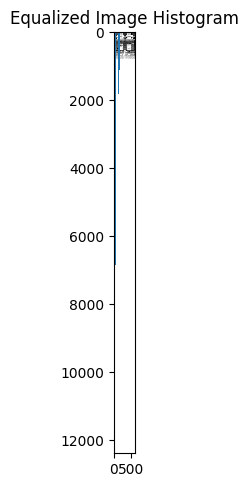

In [24]:
#5 Normalize to 0-255 range & convert to integer

eq_lut = lut_equalization(imgWalking)
equalized = eq_lut[imgWalking.astype(np.uint8)]
equalized = ((equalized - equalized.min()) * (255.0 / (equalized.max() - equalized.min()))).round().astype(np.uint8)
imshow(equalized)

#Show histogram

plt.hist(equalized.ravel(), bins=256, range=(0, 256))
plt.title('Equalized Image Histogram')
plt.show()

As we can see, the peaks of the original histogram have been stretched to use more values, while the lower values were compressed together. This allows us to fully use the entire dynamic range, better than with the auto-level. However, the change is much more noticeable and produces an image that doesn't look natural. Depending on the application, it may or may not be interesting to do it. Here, for instance, details on the windows are more noticeable, but the image gets a "grainy" look.

**Need more help? You can check the following videos:**

* [Look-Up Tables](https://www.youtube.com/watch?v=PHiiKoSsVac&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=13)
* [Auto-levels](https://www.youtube.com/watch?v=DLN4jfBJakQ&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=14)
* [Equalization](https://www.youtube.com/watch?v=C44WuMUudik&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=15)

## 2. Kernel convolution

A convolution (in image processing) is a transformation of an image by a kernel. Each pixel from the original image will be replaced by the sum of all pixels from the neighbourhood defined by the kernel size multiplied element-wise with the values of the kernel. 

Although the convolution operation is available in the scipy library, but before using it we want to code it so as to really understand what's happening. Let's use a small:

In [11]:
# The "image" will be a 5x5 array
a = np.arange(25).reshape((5,5))
new_a = a.copy()
print("a")
print(a)

# We take a 3x3 kernel
k = np.arange(9).reshape((3,3))-4
print("k")
print(k)

# What will the new value of the pixel "6" be in the new image ?
# We have to center the kernel on that pixel, and multiply all the corresponding values:
conv_6 = a[0:3,0:3]*k
print("multiplying neighbourhood of '6' by kernel")
print(conv_6)

# Then we sum those values
new6 = conv_6.sum()
new_a[1,1] = new6

print("image with new value for '6'")
print(new_a)

a
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
k
[[-4 -3 -2]
 [-1  0  1]
 [ 2  3  4]]
multiplying neighbourhood of '6' by kernel
[[ 0 -3 -4]
 [-5  0  7]
 [20 33 48]]
image with new value for '6'
[[ 0  1  2  3  4]
 [ 5 96  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


The most difficult part of the operation is to decide what to do about the borders. What's the neighbourhood of the "0" pixel in the previous example? 

Some common strategies are zero-padding (adding 0s all around the image) or same-padding (giving the pixels "around" the image the same value as the pixel closest to them). Another strategy is to just ignore those and to reduce the size of the image after the convolution.

Now let's make a function to do the convolution on the whole image, using zero-padding:

C:\Users\tajan\AppData\Local\Temp\ipykernel_6212\415890314.py:19: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(new_im)


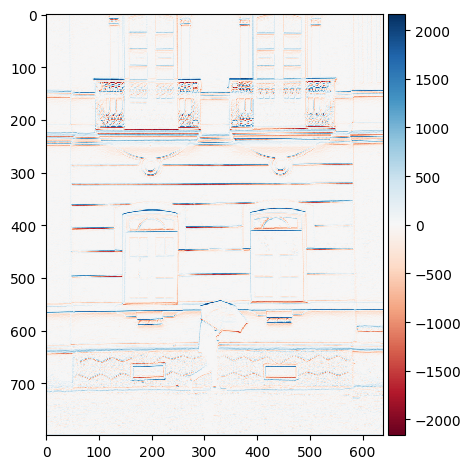

In [34]:
def convolve(im,k):
    #get dimensions 
    new_im = im.copy()
    im_h, im_w = im.shape

    for i in range(1, im_h-1):
        for j in range(1, im_w-1):
            #extracting the region of interest
            region = im[i-1:i+2, j-1:j+2]
            #element-wise multiplication and summation
            conv_value = np.sum(region * k)
            #assigning the convolved value to the new image
            new_im[i,j] = conv_value
    
    return new_im

K = conv_6
new_im = convolve(imgWalking, k)
imshow(new_im)

As we can see, this particular kernel has the effect of blurring slightly the image. A bigger kernel would blur it more.

For the next part, we will use the skimage implementations of the mean & median filters and see how they perform at noise reduction. We start with the noisy image, and try some mean filters with different sizes.

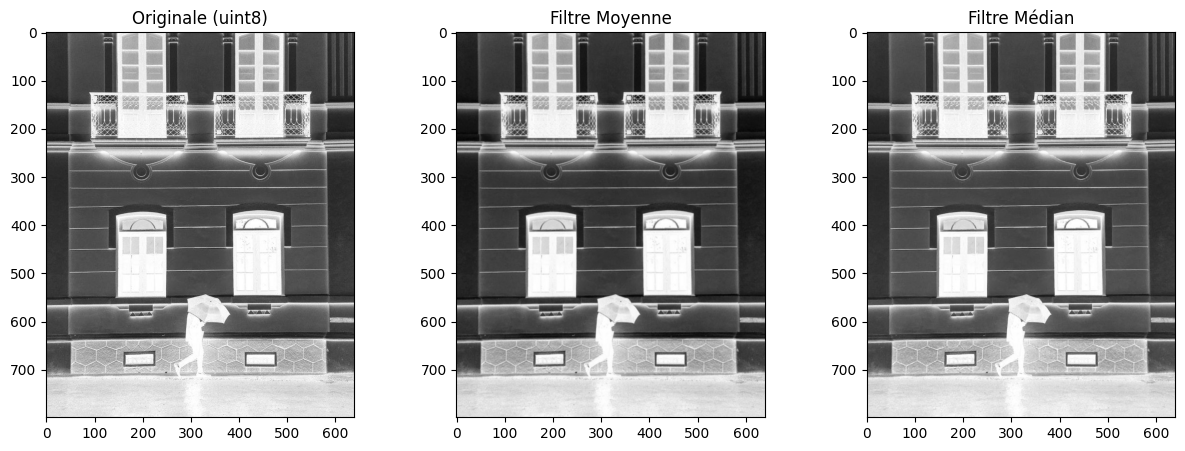

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters.rank import mean, median
from skimage.morphology import disk
from skimage.color import rgb2gray

# 0. Si l'image est en couleur, on la passe en niveaux de gris
# Note: rgb2gray renvoie souvent des floats entre 0 et 1
if imgWalking.ndim == 3:
    img_gray = rgb2gray(imgWalking)
else:
    img_gray = imgWalking

# 1. CONVERSION ROBUSTE (Le cœur de la correction)
# On vérifie le max pour savoir comment convertir
if img_gray.max() <= 1.0:
    # Cas A : L'image est en float entre 0.0 et 1.0 -> on multiplie par 255
    img_uint = (img_gray * 255).astype(np.uint8)
else:
    # Cas B : L'image est en float entre 0 et 255 -> on force le type entier
    # Cela supprime l'erreur "must be between -1 and 1"
    img_uint = img_gray.astype(np.uint8)

# 2. Application des filtres (maintenant sans erreur car img_uint est propre)
mean_img = mean(img_uint, disk(1))
median_img = median(img_uint, disk(1))

# 3. Affichage
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img_uint, cmap='gray')
ax[0].set_title('Originale (uint8)')

ax[1].imshow(mean_img, cmap='gray')
ax[1].set_title('Filtre Moyenne')

ax[2].imshow(median_img, cmap='gray')
ax[2].set_title('Filtre Médian')

plt.show()

As we can see, the noise is reduced, but we lose a lot of details on the image. Compare with the median filter:

In [ ]:
## -- Your code here -- ##

We see that the median filter removes the salt and pepper noise almost entirely, while keeping the image sharp. Even when using a larger kernel, the main borders of the image are still visible.

**Need more help? You can check the following videos:**

* [Kernel convolution](https://www.youtube.com/watch?v=FaTvGWPnLng&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=16)
* [Mean and Median filters](https://www.youtube.com/watch?v=GLTuF3lwDLs&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=17)

## 3. 2D Fourier transform

The 2D Fourier transform allows us to get a representation of the spatial frequencies present in an image. A very powerful way of filtering images is to modify those frequencies directly by modifying the "Fourier image", and to use the inverse transform to get the pixel values of the filtered image.

Let's illustrate that with a fake example. We start with a completely random signal and compute the Fourier transform. Note that the Fourier image is complex, so we use its amplitude. As the range of amplitudes is so high that we don't see much in the resulting image, we display the log of the amplitude.

In [ ]:
from numpy.fft import fft2,ifft2,fftshift,ifftshift
# fft2 -> Fourier transform
# ifft2 -> Inverse transform
# fftshift & ifftshift -> reorganize the "Fourier image" to make it more easily interpretable.

## -- Your code here -- ##

We could now, for instance, decide to add an horizontal frequency by creating peaks in the Fourier image on the horizontal axis. The further away from the center we put the peaks, the higher the frequency.

In [ ]:
## -- Your code here -- ##

Now we could also decide to mask the central region, which would remove the peaks that we just created and put all those values at zero. The image will once again look random:

In [ ]:
## -- Your code here -- ##

Starting from those examples and the code below:

1. Use the Fourier transform to reduce the [dithering](https://en.wikipedia.org/wiki/Dither) of the *moire.png* image by building a low-pass filter.
1. Build a high-pass filter using Fourier transform and apply the filter to the "walking" image.

In [ ]:
from numpy.fft import fft2,ifft2,fftshift,ifftshift


def fourier(im)
    ## -- Your code here -- ##

def ifourier(f):
    ## -- Your code here -- ##

We can see that the Fourier transform of this image has many very distinct peaks, which indicates a very repetitive pattern, much more pronouced than in the "walking" image.

So how can we use that to improve the moire image and remove the dithering ?

This dithering is "encoded" in the high frequency peaks. What happens if we remove those and only keep the "center" of the Fourier image ?

In [ ]:
# Quick function to create a disk shaped mask to apply to our Fourier image
def get_disk_mask(r, imshape)
    ## -- Your code here -- ##

In [ ]:
# Only keep the low frequencies
## -- Your code here -- ##

This operation is actually a low-pass filter, which removes the high frequencies. In the same way, we can create a high-pass filter to only let those high frequencies pass.

In [ ]:
def high_pass(im,r):
    ## -- Your code here -- ##

This produces a sort of border detector, which we can see a lot better if we take the absolute value:

In [ ]:
## -- Your code here -- ##

**Need more help? You can check the following videos:**

* [Understanding the 2D Fourier transform](https://www.youtube.com/watch?v=bsNQpeBZ7IY&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=18)
* [Filters in Fourier space](https://www.youtube.com/watch?v=8g-sE7wkKpU&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=19)

## 4. Morphological operations

Morphology is a broad set of image processing operations that process images based on shapes.

The most basic morphological operations are dilation and erosion. Dilation adds pixels to the boundaries of objects in an image, while erosion removes pixels on object boundaries. 

Most morphological operations are not performed using either dilation or erosion; instead, they are performed by using both. Two most widely used compound operations are: 
1. Opening: by first performing erosion and then dilation.
1. Closing: by first performing dilation and then erosion


For morphology functions, [see the skimage documentation](http://scikit-image.org/docs/dev/api/skimage.morphology.html?highlight=morphology#module-skimage.morphology)

Let's work with opening and closing on **circles.png**


In [ ]:
#Load circles.png and display

import skimage.filters.rank as skr
from skimage.morphology import disk
## -- Your code here -- ##

The opening operation with a disk structuring element allows us to remove circles smaller than the disk. Thus, we can count how many disks we remove when we progressively increase this radius. This gives us a count of the number of disks per radius.

1. Using the "opening" operation with a disk structuring element of increasing size, determine how many circles of any given radius there are in the *circles.png* image.
1. Build a morphological filter that eliminates one size of circles.

In [ ]:
from skimage.morphology import erosion, dilation
# Opening = dilation(erosion(image))

def opening(im,sel):
    ## -- Your code here -- ##

To determine how many circles have disappeared, we have to look at the difference between the image pre- opening and the image post-opening. Let's open the image by progressively larger disks, and count the number of pixels in the remaining image at each step.

In [ ]:
## -- Your code here -- ##

We can see that the number of remaining pixels mostly remains flat (when the opening didn't remove anything), except for some radius where we suddenly remove many pixels: this corresponds to the radius of the circles. If we divide the "removed pixels" by the "size of the circle", which can be either given by the sum of the structuring element or by $πr^2$, we should get the number of circles removed.

In [ ]:
## -- Your code here -- ##

As we can see, it's far from perfect, particularly for the smaller circles : that's because the shape of the structuring element is not exactly the same as the circles in the image, which means we have a sort of "border effect", with sometimes the borders of the circle remaining after we substract the opened image, or the shape of the circle being modified by the opening operation. We can see that in action easily :

In [ ]:
## -- Your code here -- ##

The "opened" image looks fine, but if we substract it from the original we see that the opening didn't completely restore the circle to their original shape. Still, it's enough to tell us at which radius we can expect to find circles, which should allow us to start trying to eliminate one specific size of circle.

In [ ]:
def remove_circle(im,r):
    ## -- Your code here -- ##

As we can see, the border effect is very visible. We can get a cleaner image by adding another opening with a very small radius just to "clean up" the noise from the image.

In [ ]:
def remove_circle(im,r):
    ## -- Your code here -- ##

**Need more help? You can check the following videos:**

* [Morphological operations](https://www.youtube.com/watch?v=b64M2dZaWPA&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=20)

## 5. Edge detection

We have used convolution before to apply a mean filter to blur the image. Other kernels will give other types of output. An example is the Sobel filter, which can be used for edge detection. The goal is to combine an horizontal border detector with a vertical border detector, which both use convolution.

The aim is to use the [convolve2d](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.convolve2d.html) function to develop the Sobel filter. 

The Sobel operator is given by
$$\mathbf{G} = \sqrt{ {\mathbf{G}_x}^2 + {\mathbf{G}_y}^2 }$$
where $G_x$ and $G_y$ are images respectively obtained by a convolution.


**Apply the Sobel filter** to find the edges in the "road" image.

In [ ]:
from skimage.data import camera
from skimage.io import imread
from scipy.signal import convolve2d

## -- Your code here -- ##
    

The result is very noisy since the Sobel filter is very sensitive to high frequency textures. One way to only get the more meaningful borders could be to combined it with a median filter.

Try applying it:

In [ ]:
from skimage.filters.rank import median
from skimage.morphology import disk
## -- Your code here -- ##

We can see that the result is much cleaner.



Another common edge detector is the Canny edge filter, which takes as parameter the standard deviation of the gaussian filter which, like we just did for the Sobel, is applied at the beginning of the algorithm.


Compare with the results of the **Canny edge filter** with different "sigma" values (see [the skimage documentation](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html))

In [ ]:
from skimage.feature import canny
## -- Your code here -- ##

The Canny edge filter, unlike Sobel, produces a binary result. We would get something similar by thresholding the Sobel filter.

We can now use this image as the basis for the **[Hough transform](http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html)**, to try to detect the main straight lines in the image. 

First, we can look at the image in "Hough space".

In [ ]:
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line

## -- Your code here -- ##

One way of finding the lines is to search for the peaks in Hough space. We can then represent them on the image:

In [ ]:
## -- Your code here -- ##

Try to reduce the number of lines by reducig the number of peaks:

In [ ]:
## -- Your code here -- ##

We could also use the **[Probabilistic Hough transform](https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html)**, which directly gives us line segments from the edge image:

In [ ]:
## -- Your code here -- ##

We can apply the same to the **walking.jpg** image. Adjusting the threshold allows us to select only the strongest lines.

In [ ]:
## -- Your code here -- ##

**Need more help? You can check the following videos:**

* [Edge detection with the Sobel filter](https://www.youtube.com/watch?v=QCjh8yyW-Wo&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=21)
* [Edge detection with the Canny transform](https://www.youtube.com/watch?v=yS5NnpWmuuI&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=22)
* [Line detection with the Hough Transform](https://www.youtube.com/watch?v=GD2xipfKQyY&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=23)

# Coding project - Picture enhancement

Write code that automatically enhances a photograph.

<img src="etretat.jpg" width="250px" />
<img src="ex_enhance.jpg" width="250px" />

"Enhance" may mean a lot of different things, and we encourage you to be creative in which enhancements you want to implement.

Some possibilities include (not an exhaustive list):

* Noise reduction
* Auto-level
* Gamma correction (with gamma provided by the user or automatically determined from the image histogram)
* Increase colour saturation
* ...

In [ ]:

# -- Your code here -- #
